In [30]:
import geopandas as gpd
import folium
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
#  read bus tap in tap out data

bus_passenger = pd.read_csv("../data/cleaned/ridership/bus_tap_in_out.csv")
bus_passenger.head()

,YEAR_MONTH,DAY_TYPE,PT_TYPE,PT_CODE,TIME_CATEGORY,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
0,2024-08,WEEKDAY,BUS,1012,Evening Off Peak,7091,4667
1,2024-08,WEEKDAY,BUS,1012,Evening Peak,4670,4249
2,2024-08,WEEKDAY,BUS,1012,Morning Off Peak,7769,14992
3,2024-08,WEEKDAY,BUS,1012,Morning Peak,1217,3064
4,2024-08,WEEKDAY,BUS,1013,Evening Off Peak,6615,3366


### Aggregate Ridership by Time and Day Type

Hypothesis is some areas will have high tap ins and outs in different times of the days

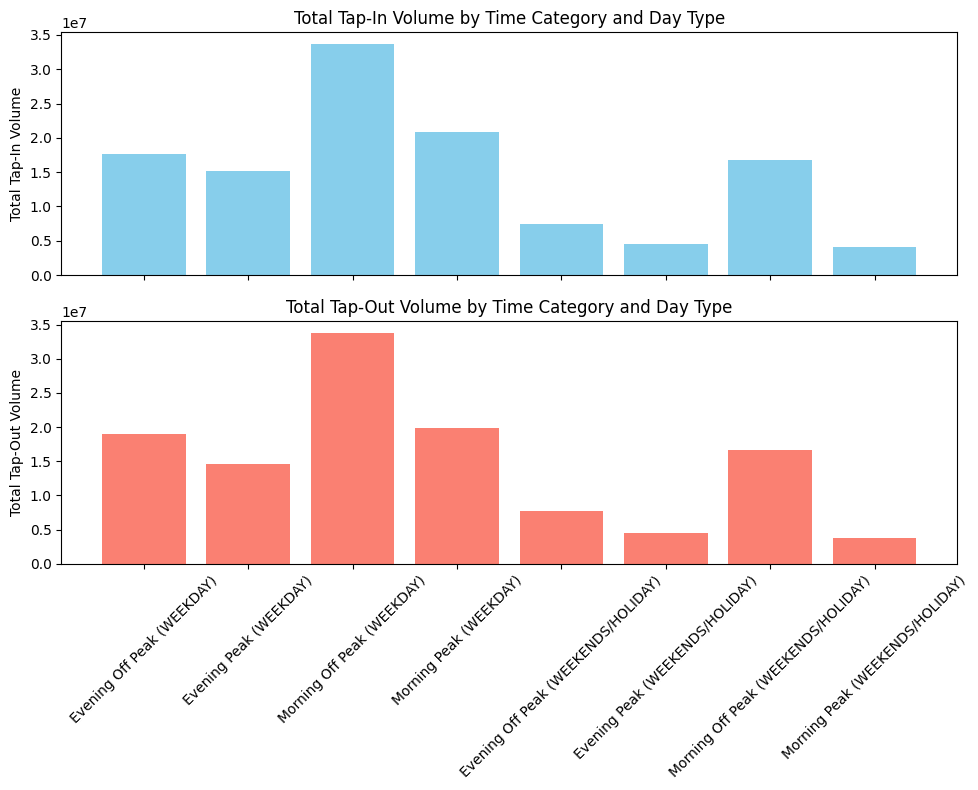

In [4]:
ridership_summary = bus_passenger.groupby(['DAY_TYPE', 'TIME_CATEGORY'])[['TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME']].sum().reset_index()
# Plot the aggregated data
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot for TOTAL_TAP_IN_VOLUME
ax[0].bar(ridership_summary['TIME_CATEGORY'] + " (" + ridership_summary['DAY_TYPE'] + ")",
           ridership_summary['TOTAL_TAP_IN_VOLUME'], color='skyblue')
ax[0].set_title('Total Tap-In Volume by Time Category and Day Type')
ax[0].set_ylabel('Total Tap-In Volume')
ax[0].tick_params(axis='x', rotation=45)

# Plot for TOTAL_TAP_OUT_VOLUME
ax[1].bar(ridership_summary['TIME_CATEGORY'] + " (" + ridership_summary['DAY_TYPE'] + ")",
           ridership_summary['TOTAL_TAP_OUT_VOLUME'], color='salmon')
ax[1].set_title('Total Tap-Out Volume by Time Category and Day Type')
ax[1].set_ylabel('Total Tap-Out Volume')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Trip Frequency and Patterns:

calculate the total number of trips for each DAY_TYPE and TIME_PER_HOUR by aggregating the TOTAL_TRIPS across different PT_CODE pairs. This will highlight peak hours and the trip frequency distribution.

In [8]:
bus_trips = pd.read_csv("../data/cleaned/ridership/bus_origin_destination.csv")
bus_trips.head()

,YEAR_MONTH,DAY_TYPE,PT_TYPE,ORIGIN_PT_CODE,DESTINATION_PT_CODE,TIME_CATEGORY,TOTAL_TRIPS
0,2024-08,WEEKDAY,BUS,1012,1112,Evening Off Peak,240
1,2024-08,WEEKDAY,BUS,1012,1112,Evening Peak,311
2,2024-08,WEEKDAY,BUS,1012,1112,Morning Off Peak,947
3,2024-08,WEEKDAY,BUS,1012,1112,Morning Peak,169
4,2024-08,WEEKDAY,BUS,1012,1113,Evening Off Peak,278


In [12]:
# Group by 'DAY_TYPE' and 'TIME_PER_HOUR', then sum 'TOTAL_TRIPS'
bus_trips.groupby(['DAY_TYPE', 'TIME_CATEGORY'])['TOTAL_TRIPS'].sum().reset_index()



,DAY_TYPE,TIME_CATEGORY,TOTAL_TRIPS
0,WEEKDAY,Evening Off Peak,17587970
1,WEEKDAY,Evening Peak,15182331
2,WEEKDAY,Morning Off Peak,33675484
3,WEEKDAY,Morning Peak,20810436
4,WEEKENDS/HOLIDAY,Evening Off Peak,7394901
5,WEEKENDS/HOLIDAY,Evening Peak,4507022
6,WEEKENDS/HOLIDAY,Morning Off Peak,16736510
7,WEEKENDS/HOLIDAY,Morning Peak,4091067


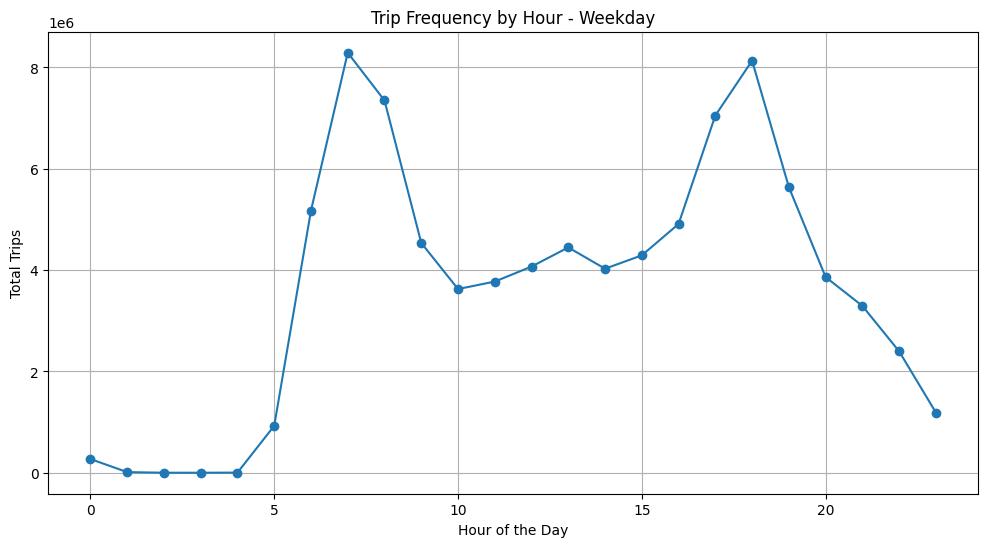

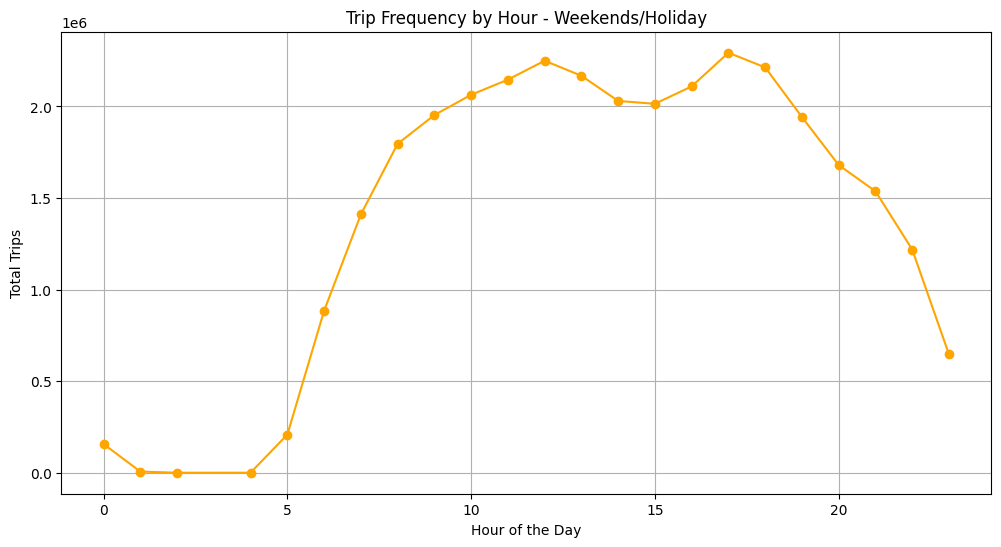

In [14]:
# Read the old data
bus_trips_old = pd.read_csv("../data/Passengers_Aug2024/origin_destination_bus_202408.csv")

# Group by 'DAY_TYPE' and 'TIME_PER_HOUR', then sum 'TOTAL_TRIPS'
trip_frequency = bus_trips_old.groupby(['DAY_TYPE', 'TIME_PER_HOUR'])['TOTAL_TRIPS'].sum().reset_index()


# Separate data for weekday and weekend/holiday
weekday_data = trip_frequency[trip_frequency["DAY_TYPE"] == "WEEKDAY"]
weekend_data = trip_frequency[trip_frequency["DAY_TYPE"] == "WEEKENDS/HOLIDAY"]

# Plotting trip frequency for WEEKDAY
plt.figure(figsize=(12, 6))
plt.plot(weekday_data['TIME_PER_HOUR'], weekday_data['TOTAL_TRIPS'], marker='o')
plt.title("Trip Frequency by Hour - Weekday")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Trips")
plt.grid(True)
plt.show()

# Plotting trip frequency for WEEKENDS/HOLIDAY
plt.figure(figsize=(12, 6))
plt.plot(weekend_data['TIME_PER_HOUR'], weekend_data['TOTAL_TRIPS'], marker='o', color='orange')
plt.title("Trip Frequency by Hour - Weekends/Holiday")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Trips")
plt.grid(True)
plt.show()

From the analysis we didnt learn anything new about the trip trend. As expected peak hours have a more trips then non peak

### Identify potential bus Servies that run throughts the origin and desitnation route

In [26]:
# Read the bus routes json
bus_routes = pd.read_json("../data/cleaned/BusRoutes.json", lines=True)

In [89]:
# Merge bus trip data with bus passanger data
merged_bus_data = pd.merge(
    bus_trips,
    bus_passenger,
    left_on=["YEAR_MONTH", "DAY_TYPE", "PT_TYPE", "ORIGIN_PT_CODE", "TIME_CATEGORY"],
    right_on=["YEAR_MONTH", "DAY_TYPE", "PT_TYPE", "PT_CODE", "TIME_CATEGORY"],
    how="left"
)

# Drop the redundant PT_CODE column from the merge
merged_bus_data = merged_bus_data.drop(columns=["PT_CODE"])

# Display the merged result
print("Merged Data:")
print(merged_bus_data)



Merged Data:
        YEAR_MONTH          DAY_TYPE PT_TYPE  ORIGIN_PT_CODE  \
0          2024-08           WEEKDAY     BUS            1012   
1          2024-08           WEEKDAY     BUS            1012   
2          2024-08           WEEKDAY     BUS            1012   
3          2024-08           WEEKDAY     BUS            1012   
4          2024-08           WEEKDAY     BUS            1012   
...            ...               ...     ...             ...   
1838888    2024-08  WEEKENDS/HOLIDAY     BUS           99189   
1838889    2024-08  WEEKENDS/HOLIDAY     BUS           99189   
1838890    2024-08  WEEKENDS/HOLIDAY     BUS           99189   
1838891    2024-08  WEEKENDS/HOLIDAY     BUS           99189   
1838892    2024-08  WEEKENDS/HOLIDAY     BUS           99189   

         DESTINATION_PT_CODE     TIME_CATEGORY  TOTAL_TRIPS  \
0                       1112  Evening Off Peak          240   
1                       1112      Evening Peak          311   
2                       1112 

In [86]:
# Find bus services that go from the origin to destination with specific direction
def find_bus_services(origin, destination, df):
    # Filter for services containing both origin and destination
    services_with_origin = df[df['BusStopCode'] == origin]
    services_with_destination = df[df['BusStopCode'] == destination]
    
    # Merge to find common services and directions
    merged = pd.merge(services_with_origin, services_with_destination, on=['ServiceNo', 'Direction'], suffixes=('_origin', '_destination'))
    
    # Filter where origin appears before destination in the StopSequence
    potential_services = merged[merged['StopSequence_origin'] < merged['StopSequence_destination']]
    
    # Select relevant columns, including StopSequence for origin and destination
    result = potential_services[['ServiceNo', 'Direction', 'StopSequence_origin', 'StopSequence_destination']].drop_duplicates()
    return result

# Example usage:
origin_pt_code = 24009
destination_pt_code = 24009
potential_services = find_bus_services(origin_pt_code, destination_pt_code, bus_routes)

print("Potential bus services and directions between origin and destination:")
print(potential_services)

Potential bus services and directions between origin and destination:
   ServiceNo  Direction  StopSequence_origin  StopSequence_destination
1        182          1                    1                        61
5       182M          1                    1                        60
9        253          1                    1                        24
13       254          1                    1                        42
17       255          1                    1                        24
21       257          1                    1                        39
25       258          1                    1                        41
29       974          1                    1                        54


In [114]:
# Step 1: Function to find potential bus services
def find_bus_services(start, end, df):
    # Filter for services containing both start and end stops
    services_with_start = df[df['BusStopCode'] == start]
    services_with_end = df[df['BusStopCode'] == end]
    
    # Merge to find common services and directions
    merged = pd.merge(services_with_start, services_with_end, on=['ServiceNo', 'Direction'], suffixes=('_start', '_end'))
    
    # Filter where start appears before end in the StopSequence
    potential_services = merged[merged['StopSequence_start'] < merged['StopSequence_end']]
    
    # Return relevant columns, including StopSequence for start and end
    return potential_services[['ServiceNo', 'Direction', 'StopSequence_start', 'StopSequence_end']]

# Step 2: Get route segments with stops in between
def get_route_stops(start, end, bus_routes_df, find_bus_services_fn):
    # Identify potential bus services from start to end
    potential_services = find_bus_services_fn(start, end, bus_routes_df)
    
    # List to store route data for each service
    route_segments = []
    
    for _, service in potential_services.iterrows():
        # Filter for this specific service and direction
        service_df = bus_routes_df[(bus_routes_df['ServiceNo'] == service['ServiceNo']) & 
                                   (bus_routes_df['Direction'] == service['Direction'])]
        
        # Get stops from start to end
        route_segment = service_df[(service_df['StopSequence'] >= service['StopSequence_start']) & 
                                   (service_df['StopSequence'] <= service['StopSequence_end'])]
        
        # Add the route segment to the list, including ServiceNo and Direction
        route_segment['ServiceNo'] = service['ServiceNo']
        route_segment['Direction'] = service['Direction']
        route_segments.append(route_segment)
    
    return pd.concat(route_segments, ignore_index=True)

# Step 3: Match tap data to identified route segments
def get_tap_data_for_route(route_df, tap_volumes_df):
    # Merge tap data based on PT_CODE and BusStopCode
    tap_data_route = pd.merge(route_df, tap_volumes_df, 
                              left_on="BusStopCode", right_on="ORIGIN_PT_CODE", how="left")
    
    # Drop duplicate rows based on key columns to retain only one instance per combination
    tap_data_route = tap_data_route.drop_duplicates(
        subset=['ServiceNo', 'Direction', 'BusStopCode', 'StopSequence', 'DAY_TYPE', 'TIME_CATEGORY']
    )
    
    # Calculate net volume (tap-in minus tap-out) for each stop
    tap_data_route['Net_Volume'] = tap_data_route['TOTAL_TAP_IN_VOLUME'] - tap_data_route['TOTAL_TAP_OUT_VOLUME']
    
    # Select relevant columns for display
    return tap_data_route[['ServiceNo', 'Direction', 'ORIGIN_PT_CODE', 'StopSequence', 'DAY_TYPE', 
                           'TIME_CATEGORY', 'TOTAL_TRIPS','TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME', 'Net_Volume']]


In [124]:
# Construct the route graph
start_stop = 22009  # Example start stop code
end_stop = 22509    # Example end stop code
# Step 1 & 2: Get route segments for each service from start to end
route_segments = get_route_stops(start_stop, end_stop, bus_routes, find_bus_services)

route_with_rider_data = get_tap_data_for_route(route_segments,merged_bus_data)

#print(route_segments.head(10))
print(route_with_rider_data.head(10))

     ServiceNo  Direction  ORIGIN_PT_CODE  StopSequence          DAY_TYPE  \
0          179          1           22009             1           WEEKDAY   
1          179          1           22009             1           WEEKDAY   
2          179          1           22009             1           WEEKDAY   
3          179          1           22009             1           WEEKDAY   
2337       179          1           22009             1  WEEKENDS/HOLIDAY   
2338       179          1           22009             1  WEEKENDS/HOLIDAY   
2339       179          1           22009             1  WEEKENDS/HOLIDAY   
2340       179          1           22009             1  WEEKENDS/HOLIDAY   
4536       179          1           22501             2           WEEKDAY   
4537       179          1           22501             2           WEEKDAY   

         TIME_CATEGORY  TOTAL_TRIPS  TOTAL_TAP_IN_VOLUME  \
0     Evening Off Peak            6               411687   
1         Evening Peak          

C:\Users\user\AppData\Local\Temp\ipykernel_107240\2558964037.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_segment['ServiceNo'] = service['ServiceNo']
C:\Users\user\AppData\Local\Temp\ipykernel_107240\2558964037.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_segment['Direction'] = service['Direction']


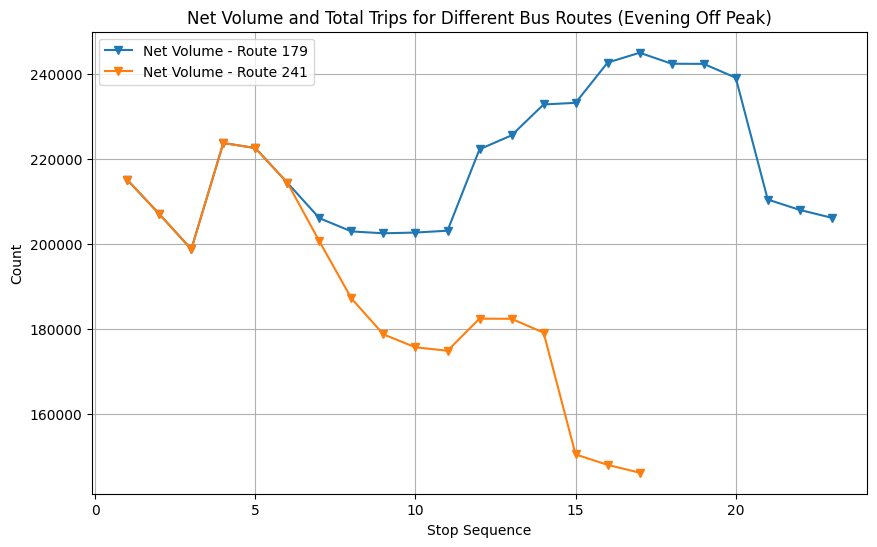

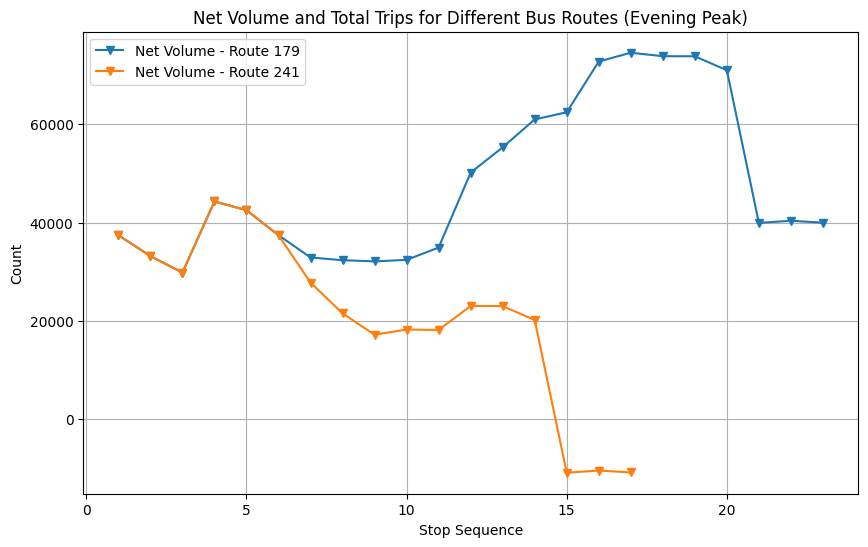

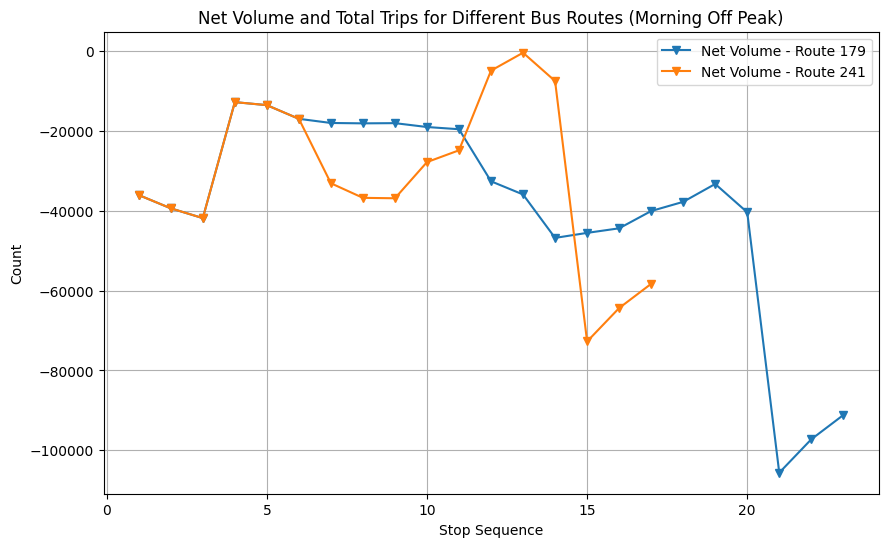

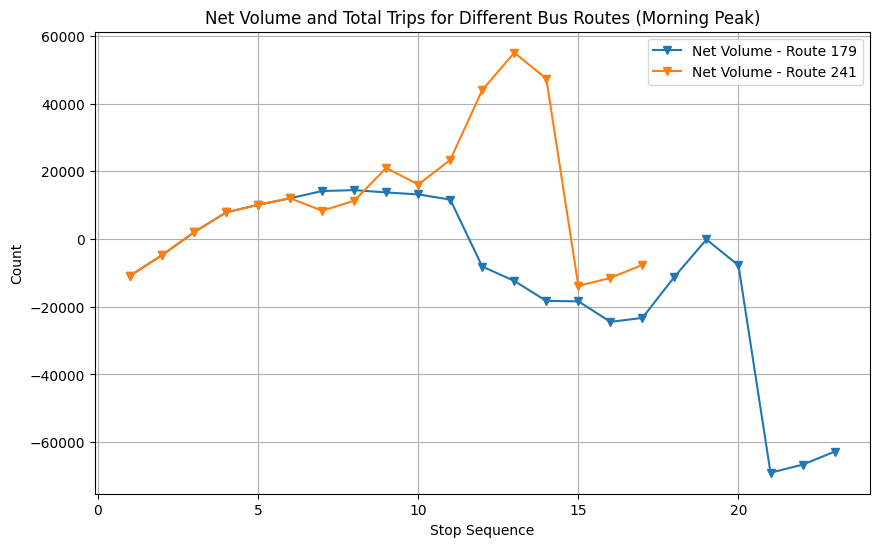

In [125]:

# Step 4: Plotting data for each time category
def plot_tap_in_out_by_time_category(route_data, time_category):
    # Filter data for the specific time category
    time_data = route_data[route_data['TIME_CATEGORY'] == time_category]
    
    # Sort by StopSequence for proper ordering
    time_data = time_data.sort_values(by='StopSequence')
    
    
    plt.figure(figsize=(10, 6))
    
    for service_no in time_data['ServiceNo'].unique():
        # Filter data for this specific route
        service_data = time_data[time_data['ServiceNo'] == service_no].sort_values(by='StopSequence')
        service_data['Cumulative_Net_Volume'] = service_data['Net_Volume'].cumsum()
        
        # Plot net volume for this route
        plt.plot(service_data['StopSequence'], service_data['Cumulative_Net_Volume'], label=f"Net Volume - Route {service_no}", marker='v')
        
        # Plot total trips for this route
        #plt.plot(service_data['StopSequence'], service_data['TOTAL_TRIPS'], label=f"Total Trips - Route {service_no}", marker='o', linestyle='--')
    
    # Adding labels and title
    plt.xlabel("Stop Sequence")
    plt.ylabel("Count")
    plt.title(f"Net Volume and Total Trips for Different Bus Routes ({time_category})")
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Get unique time categories for looping
time_categories = route_with_rider_data['TIME_CATEGORY'].unique()

# Loop through each time category and plot
for time_category in time_categories:
    plot_tap_in_out_by_time_category(route_with_rider_data[route_with_rider_data['DAY_TYPE'] == 'WEEKDAY'], time_category)

